In [2]:
import jax
from jax import numpy as jnp
import numpy as np
import utils
import constants as const
import copy, time
import matplotlib
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

plt.rcParams['font.family'] = 'STIXGeneral'  # Closely matches Computer Modern
plt.rcParams['mathtext.fontset'] = 'stix'    # Use STIX for math

In [3]:
jax.config.update("jax_enable_x64", True)

### Binary and timing properties [default]

In [2]:
pars = dict(
    cw_costheta=0.0,
    cw_phi=0.0,
    cw_cosinc=0.99,
    cw_log10_Mc=10.5,
    cw_log10_fgw=-8.,
    cw_log10_dist=2.385,
    cw_phase0=0.,
    cw_psi=0.,
)


# Define 100 TOAs over 10 years at 10 per year, with 100 ns errors
t0 = 58000.0 * 86400.0
t1 = t0 + 10.0 * 365.25 * 86400.0
toas_new = jnp.linspace(t0, t1, 100)
toaerrs = jnp.full_like(toas_new, 1e-6)

### Exploring angular resolution by pulsar proximity

In [22]:
psrs_ring = utils.pulsar_ring_generator(pars=pars, ang_radius=30.0, npsrs=5, 
                                        toas=toas_new, toaerrs=toaerrs, pdist=[1.0,0.5])

/Users/taylosr8/Research/repos/pta_cw_fisher/utils.py:49: FutureWarning: None encountered in jnp.array(); this is currently treated as NaN. In the future this will result in an error.
  self.design_matrix = jnp.array(design_matrix)


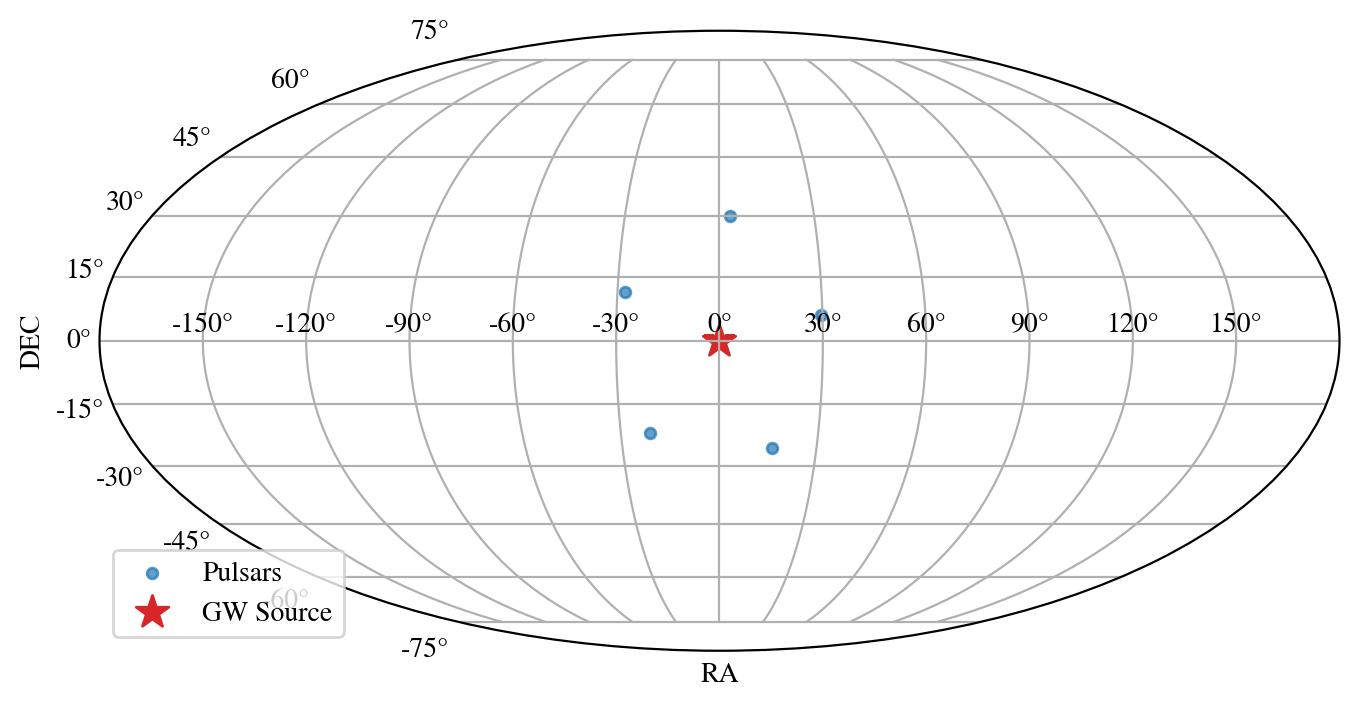

In [23]:
ra_ring = jnp.array([p.ra for p in psrs_ring])
dec_ring = jnp.array([p.dec for p in psrs_ring])
# Mollweide projection of pulsar sky locations and GW source
# wrap RA into [-π, +π] for plotting
ra_wrap = (ra_ring + jnp.pi) % (2 * jnp.pi) - jnp.pi

# GW source sky coords from pars
gw_dec = jnp.arcsin(pars['cw_costheta'])
gw_ra  = (pars['cw_phi'] + jnp.pi) % (2 * jnp.pi) - jnp.pi

fig = plt.figure(figsize=(8,5))
ax = fig.add_subplot(projection='mollweide')
ax.scatter(ra_wrap, dec_ring, s=15, color='C0', alpha=0.7, label='Pulsars')
ax.scatter(gw_ra,   gw_dec, s=150, color='C3', marker='*', label='GW Source')
ax.grid(True)
ax.set_xlabel('RA')
ax.set_ylabel('DEC')
ax.legend(loc='lower left')
#plt.title('Mollweide Projection of Pulsar Sky & GW Origin')
plt.show()

In [24]:
# Instantiate a CW_Signal for each pulsar in the psrs list
cw_signals = [
    utils.CW_Signal(psr=p, tref=p.toas[0], evolve=True)
    for p in psrs_ring
]

# deep-copy the dictionary so nested objects are also copied
pars_copy = copy.deepcopy(pars)
param_keys_copy = list(pars_copy.keys()) + [p.name+'_pdist' for p in psrs_ring]
param_vec_copy = jnp.array(list(pars_copy.values()) + [0.0] * len(psrs_ring))
pars_copy_full = dict(zip(param_keys_copy, param_vec_copy))

total_snr = jnp.sum(jnp.stack([utils.computer_snr2(cw,pars_copy_full,pterm=True) 
                               for cw in cw_signals]), axis=0)**0.5
pars_copy_full['cw_log10_dist'] = jnp.log10(total_snr * 10**pars['cw_log10_dist'] / 5.0)

# list of fisher matrices, one per pulsar
fishers = [utils.compute_fisher(cw,pars_copy_full,pterm=True) 
           for cw in cw_signals]
total_fisher = jnp.sum(jnp.stack(fishers), axis=0)

In [25]:
# # Construct the diagonal entries of the prior array
# diag_values = []
# for key in param_keys_copy:
#     if key.endswith('_pdist'):
#         # extract the pulsar name and find its pdist[1] value
#         psr_name = key[:-len('_pdist')]
#         sigma_pdist_val = next(p for p in psrs_ring if p.name == psr_name).pdist[1]
#         diag_values.append(1.0/sigma_pdist_val**2.0)
#     else:
#         diag_values.append(0.0)

# # create the diagonal matrix
# prior_inv = jnp.array(diag_values)

In [26]:
#total_fisher += jnp.diag(prior_inv)

In [27]:
total_fisher.shape

(13, 13)

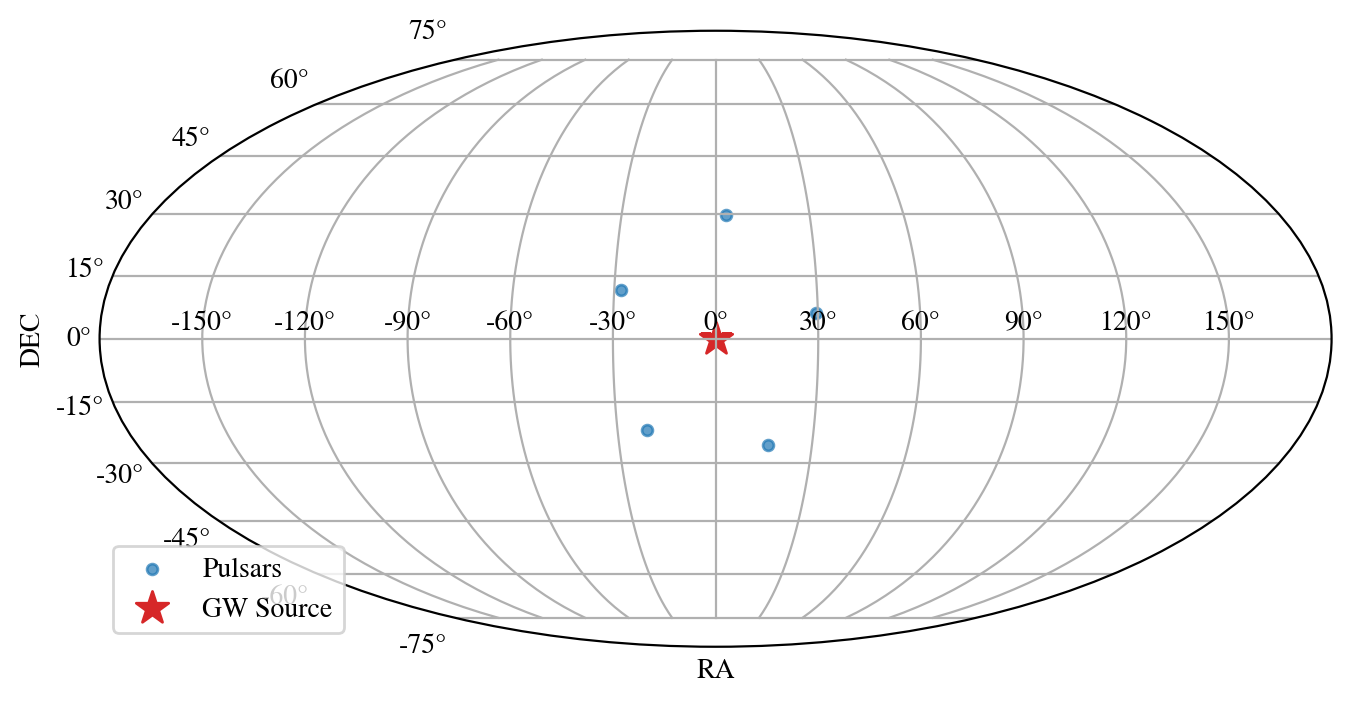

In [28]:
# Center in degrees (lon, lat)
center_uphi = (pars['cw_costheta'], pars['cw_phi'])

fig = plt.figure(figsize=(8,4))
ax = fig.add_subplot(111, projection='mollweide')
utils.plot_fisher_ellipse_on_sky(total_fisher[:2,:2], center_uphi, ax=ax,
                                edgecolor='red', facecolor='none', lw=2)
ax.scatter(ra_wrap, dec_ring, s=15, color='C0', alpha=0.7, label='Pulsars')
ax.scatter(gw_ra,   gw_dec, s=150, color='C3', marker='*', label='GW Source')
ax.grid(True)
ax.set_xlabel('RA')
ax.set_ylabel('DEC')
ax.legend(loc='lower left')
#plt.title('Mollweide Projection of Pulsar Sky & GW Origin')
plt.show()

### Fixed SNR=10 and fixed number of pulsars = 5

In [127]:
angles = jnp.linspace(0.1,179.9,100)
omega_sky_fSNR_npsr20 = []
omega_sky_fSNR_npsr20_marg = []
snrs = []
phase_free = False

for ang in angles:
    psrs_ring = utils.pulsar_ring_generator(pars=pars, ang_radius=ang, npsrs=20, 
                                            toas=toas_new, toaerrs=toaerrs, pdist=[1.0,1e-5])
    # Instantiate a CW_Signal for each pulsar in the psrs list
    cw_signals = [
        utils.CW_Signal(psr=p, tref=p.toas[0], evolve=True)
        for p in psrs_ring
                 ]
    
    ## calculate the p_phase values
    pphases = []
    for p in psrs_ring:
        # calculate antenna pattern and cosMu
        _, _, cosMu = utils.create_gw_antenna_pattern(p._pos, 
                                                      jnp.arccos(pars['cw_costheta']), 
                                                      pars['cw_phi'])
        # subtract reference time from TOAs
        toas = p.toas - p.toas[0]
        # get pulsar time
        p_dist = (p.pdist[0] + p.pdist[1] * 0.0) * const.kpc / const.c
        tp = toas - p_dist * (1 - cosMu)
        # orbital frequency and phase
        w0 = jnp.pi * 10**pars['cw_log10_fgw']
        phase0 = pars['cw_phase0'] / 2
        # evolution of frequency and phase
        mc = 10**pars['cw_log10_Mc'] * const.Tsun
        omega_p0 = w0 * (1 - 256 / 5 * mc ** (5 / 3) * w0 ** (8 / 3) * tp[0]) ** (-3 / 8)
        # calculate p_phase
        p_phase = 1 / 32 / mc ** (5 / 3) * (w0 ** (-5 / 3) - omega_p0 ** (-5 / 3))
        pphases.append(p_phase)

    # deep-copy the dictionary so nested objects are also copied
    pars_copy = copy.deepcopy(pars)
    if phase_free:
        # distance and phase
        param_keys_copy = list(pars_copy.keys()) + \
            [p.name+'_pdist' for p in psrs_ring] + \
                [p.name+'_pphase' for p in psrs_ring]
        param_vec_copy = jnp.array(list(pars_copy.values()) + \
                                   [0.0] * len(psrs_ring) + \
                                    pphases)
    else:
        # distance only
        param_keys_copy = list(pars_copy.keys()) + [p.name+'_pdist' for p in psrs_ring]
        param_vec_copy = jnp.array(list(pars_copy.values()) + [0.0] * len(psrs_ring))
    pars_copy_full = dict(zip(param_keys_copy, param_vec_copy))

    # compute the SNR and calibrate to 10 by updating the distance
    total_snr = jnp.sum(jnp.stack([utils.computer_snr2(cw,pars_copy_full,pterm=True) 
                                   for cw in cw_signals]), axis=0)**0.5
    snrs.append(total_snr)
    pars_copy_full['cw_log10_dist'] = jnp.log10(total_snr * 10**pars['cw_log10_dist'] / 10.)

    # list of fisher matrices, one per pulsar
    fishers = [utils.compute_fisher(cw,pars_copy_full,pterm=True) 
               for cw in cw_signals]
    if phase_free:
        # add prior for distance and phase
        prior_list = [0.0]*8 + [1.0 for _ in psrs_ring] + [0.0 for _ in psrs_ring]
    else:
        # add prior for distance only
        prior_list = [0.0]*8 + [1.0 for _ in psrs_ring]
    total_fisher = jnp.sum(jnp.stack(fishers), axis=0) + \
        jnp.diag(jnp.array(prior_list))

    #modified_snr = jnp.sum(jnp.stack([computer_snr2(cw,pars_copy) for cw in cw_signals]), axis=0)**0.5
    #print(total_snr, modified_snr)
    #omega_sky.append( (180/jnp.pi)**2 * 2.0*jnp.pi/jnp.linalg.det(total_fisher[:2,:2])**0.5 )

    fisher_inv = jnp.linalg.pinv(total_fisher,rtol=1e-5)[:2,:2]
    omega_sky_fSNR_npsr20.append( (180/jnp.pi)**2 * 2.0*jnp.pi / jnp.linalg.det(total_fisher[:2,:2])**0.5 )
    omega_sky_fSNR_npsr20_marg.append( (180/jnp.pi)**2 * 2.0*jnp.pi * jnp.linalg.det(fisher_inv)**0.5 )

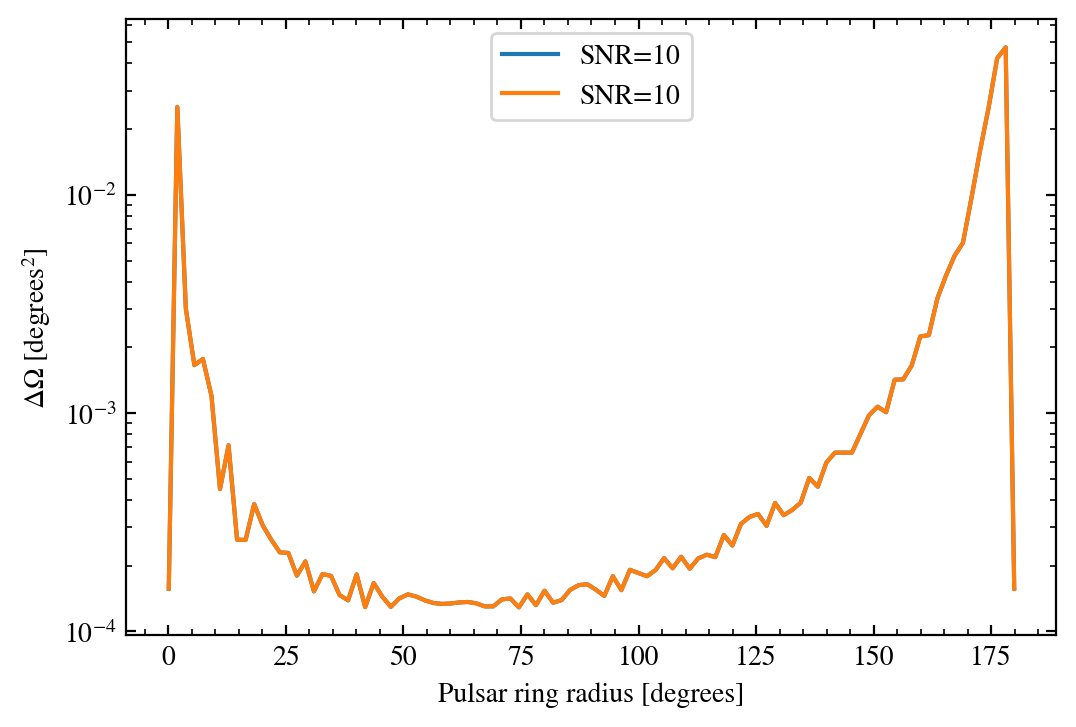

In [129]:
plt.plot(angles, jnp.array(omega_sky_fSNR_npsr20), label='SNR=10');
plt.plot(angles, jnp.array(omega_sky_fSNR_npsr20_marg), label='SNR=10');
#plt.plot(angles, jnp.array(omega_sky_cosinc0), label='SNR=10');
#plt.plot(angles, omega_sky, label='SNR=10');
#plt.plot(angles, 2.0/jnp.array(angles)**1.75, label='$\propto \\theta_\mathrm{sep}^2$')
#plt.plot(angles, jnp.array(angles)**2.0);
#plt.xscale('log')
plt.yscale('log')
plt.xlabel('Pulsar ring radius [degrees]')
plt.ylabel('$\Delta\Omega$ [degrees$^2$]')
plt.minorticks_on()
plt.tick_params(which='both',tick2On=True,direction='in')
plt.legend()

fig = matplotlib.pyplot.gcf()
fig.set_size_inches(6, 4)

plt.show()

#### Try this with fixed ring around North Pole, and GW source moved around sky

In [3]:
import healpy as hp

# set up a Healpix grid
nside = 16
npix = hp.nside2npix(nside)
print(npix)
pix_idx = jnp.arange(npix)

# get the pixel center in colatitude (θ) and longitude (φ), in radians
theta_np, phi_np = hp.pix2ang(nside, np.arange(npix))
theta_hp = jnp.array(theta_np)
phi_hp = jnp.array(phi_np)

# convert to declination and right-ascension
dec_hp = 0.5 * jnp.pi - theta_hp  # DEC = π/2 – θ
ra_hp = phi_hp                    # RA = φ

# ra_hp, dec_hp now hold the sky locations for each pixel
#ra_hp, dec_hp

3072


In [4]:
pars_map = dict(
    cw_costheta=0.999,
    cw_phi=0.0,
    cw_cosinc=0.99,
    cw_log10_Mc=9.5,
    cw_log10_fgw=-8.0,
    cw_log10_dist=2.385,
    cw_phase0=0.,
    cw_psi=0.,
)

In [44]:
from functools import partial

@partial(jax.jit, static_argnames=('npsrs','ang_radius','pterm','pdist','phase_free'))
def _compute_pixel(theta, phi,
                   pars_base,
                   toas, toaerrs,
                   npsrs=20, ang_radius=10.0,
                   pterm=True,
                   pdist=(1.0,1e-3),
                   phase_free=False):
    psrs = utils.pulsar_ring_generator(
        pars=pars_base,
        ang_radius=ang_radius,
        npsrs=npsrs,
        toas=toas,
        toaerrs=toaerrs,
        pdist=list(pdist),
    )
    cws = [utils.CW_Signal(psr=p, tref=p.toas[0], evolve=True) for p in psrs]

    pars = pars_base.copy()
    pars['cw_costheta'] = jnp.cos(theta)
    pars['cw_phi']      = phi

    if pterm:
        if phase_free:
            param_keys = list(pars.keys()) + \
                [p.name+'_pdist' for p in psrs] + \
                [p.name+'_pphase' for p in psrs]
            param_vec  = jnp.array(list(pars.values()) + [0.0]*(2*len(psrs)))
        else:
            param_keys = list(pars.keys()) + [p.name+'_pdist' for p in psrs]
            param_vec  = jnp.array(list(pars.values()) + [0.0]*len(psrs))
        pars = dict(zip(param_keys, param_vec))

    snr2 = jnp.stack([utils.computer_snr2(cw, pars, pterm=pterm) for cw in cws])
    total_snr = jnp.sqrt(jnp.sum(snr2, axis=0))
    #pars['cw_log10_dist'] = jnp.log10(total_snr * 10**pars_base['cw_log10_dist'] / 10.0)

    fishers = jnp.stack([utils.compute_fisher(cw, pars, pterm=pterm) for cw in cws])
    F = jnp.sum(fishers, axis=0)
    if pterm:
        prior_list = ([0.0]*8 +
                    [1.0 for _ in psrs] +
                    ([0.0 for _ in psrs] if phase_free else []))
        F += jnp.diag(jnp.array(prior_list))

    ω = (180/jnp.pi)**2 * 2*jnp.pi / jnp.linalg.det(F[:2,:2])**0.5
    Finv = jnp.linalg.pinv(utils.fisher_marg(pars, F))
    #ω_marg = (180/jnp.pi)**2 * 2*jnp.pi * jnp.linalg.det(Finv[:2,:2])**0.5
    ω_marg = (180/jnp.pi)**2 * 2*jnp.pi * jnp.linalg.det(Finv)**0.5
    return total_snr, ω, ω_marg

# usage with vmap (phase_free fixed -> static)
snr_map, omega_map, omega_marg_map = jax.vmap(
    partial(_compute_pixel,
            pars_base=pars_map,
            toas=toas_new,
            toaerrs=toaerrs,
            npsrs=100,
            ang_radius=10.0,
            pterm=True,
            pdist=(1.0,1e-10),
            phase_free=False),
    in_axes=(0,0)
)(theta_hp, phi_hp)

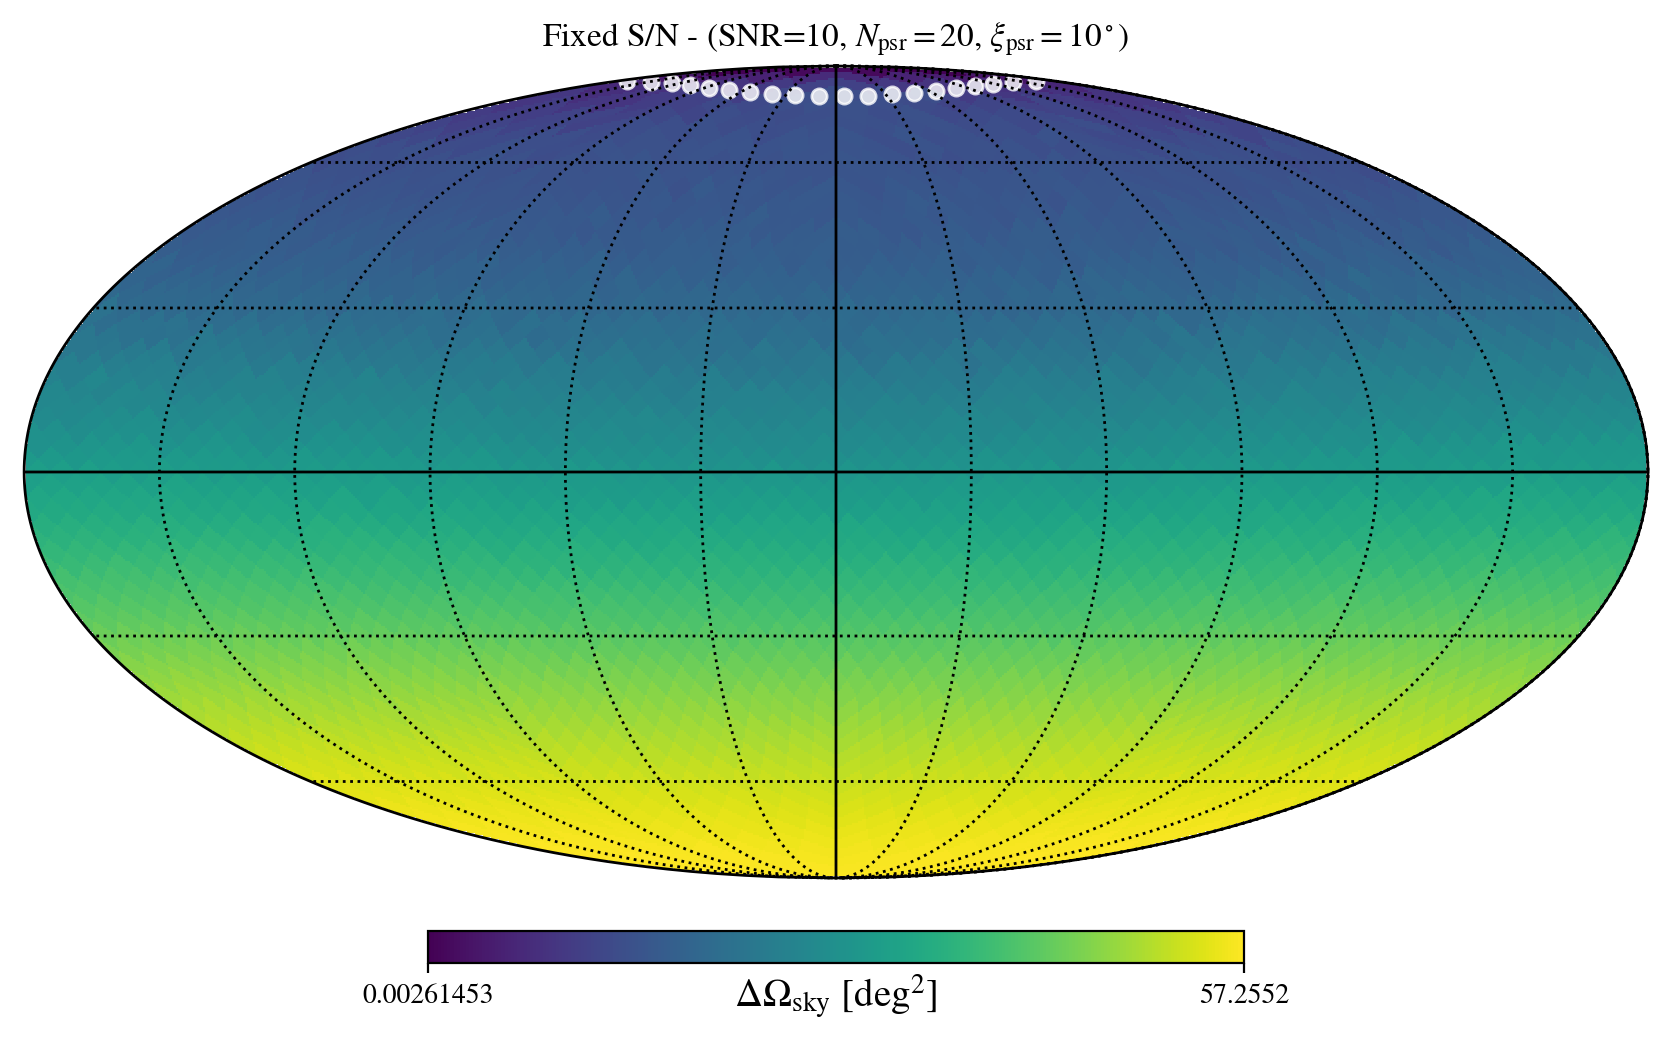

In [45]:
# Plot with a Mollweide projection
hp.mollview(omega_map,
            #title=r'Fixed binary parameters - ($N_{\rm psr}=20$, $\xi_{\rm psr}=10^\circ)$',
            title=r'Fixed S/N - (SNR=10, $N_{\rm psr}=20$, $\xi_{\rm psr}=10^\circ)$',
            unit='$\Delta\Omega_{\\rm sky}$ [deg$^2$]',
            cmap='viridis',
            norm='hist')
# overlay pulsar positions from the last psrs_ring
# generate ring of pulsars (this must itself be jittable!)
psrs_ring = utils.pulsar_ring_generator(pars=pars_map, ang_radius=10.0, npsrs=20, 
                                        toas=toas_new, toaerrs=toaerrs)
ras = np.degrees(np.array([p.ra for p in psrs_ring]))
decs = np.degrees(np.array([p.dec for p in psrs_ring]))
hp.projscatter(ras, decs, lonlat=True, s=30, color='white', marker='o', alpha=0.8)
hp.graticule()
plt.show()

### Don't fix the SNR

In [20]:
angles = jnp.linspace(1.,80.,40)
omega_sky_vsnr = []
omega_sky_vsnr_marg = []
snrs = []

seed = int(time.time() * 1e6) % (2**31 - 1)
key = jax.random.PRNGKey(seed)

for ang in angles:
    key, subkey = jax.random.split(key)
    npsrs = int(jax.random.randint(subkey, (), 10, 51))
    print(npsrs)

    # deep-copy the dictionary so nested objects are also copied
    pars_copy = copy.deepcopy(pars)
    key, subkey2 = jax.random.split(key)
    key, subkey3 = jax.random.split(key)
    key, subkey4 = jax.random.split(key)
    key, subkey5 = jax.random.split(key)
    pars_copy['cw_log10_dist'] = jax.random.uniform(subkey2, minval=2.5, maxval=4.0)
    pars_copy['cw_cosinc'] = jax.random.uniform(subkey3, minval=-0.99, maxval=0.99)
    pars_copy['cw_psi'] = jax.random.uniform(subkey4, minval=0.01, maxval=jnp.pi-0.01)
    pars_copy['cw_phase0'] = jax.random.uniform(subkey5, minval=0.01, maxval=2.0*jnp.pi-0.01)

    psrs_ring = utils.pulsar_ring_generator(pars=pars_copy, ang_radius=ang, npsrs=npsrs, 
                                            toas=toas_new, toaerrs=toaerrs)
    # Instantiate a CW_Signal for each pulsar in the psrs list
    cw_signals = [
        utils.CW_Signal(psr=p, tref=p.toas[0], evolve=False)
        for p in psrs_ring
                ]
    
    # deep-copy the dictionary so nested objects are also copied
    #pars_copy = copy.deepcopy(pars)
    total_snr = jnp.sum(jnp.stack([utils.computer_snr2(cw,pars_copy) 
                                   for cw in cw_signals]), axis=0)**0.5
    snrs.append(total_snr)
    #snrs.append([utils.computer_snr2(cw,pars_copy) for cw in cw_signals])

    #pars_copy['cw_log10_dist'] = jnp.log10(total_snr * 10**pars['cw_log10_dist'] / 10.)
    # list of fisher matrices, one per pulsar
    fishers = [utils.compute_fisher(cw,pars_copy) for cw in cw_signals]
    total_fisher = jnp.sum(jnp.stack(fishers), axis=0)
    #modified_snr = jnp.sum(jnp.stack([computer_snr2(cw,pars_copy) for cw in cw_signals]), axis=0)**0.5
    #print(total_snr, modified_snr)
    
    fisher_inv = jnp.linalg.pinv(total_fisher)[:2,:2]
    omega_sky_vsnr_marg.append( (180/jnp.pi)**2 * 2.0*jnp.pi * jnp.linalg.det(fisher_inv)**0.5 )
    omega_sky_vsnr.append( (180/jnp.pi)**2 * 2.0*jnp.pi / jnp.linalg.det(total_fisher[:2,:2])**0.5 )

23


/Users/taylosr8/Research/repos/pta_cw_fisher/utils.py:48: FutureWarning: None encountered in jnp.array(); this is currently treated as NaN. In the future this will result in an error.
  self.design_matrix = jnp.array(design_matrix)


39
44
20
15
35
27
50
35
13
30
23
14
45
23
29
30
49
24
21
18
25
24
25
10
14
17
23
30
32
41
49
46
28
48
31
43
17
32
40


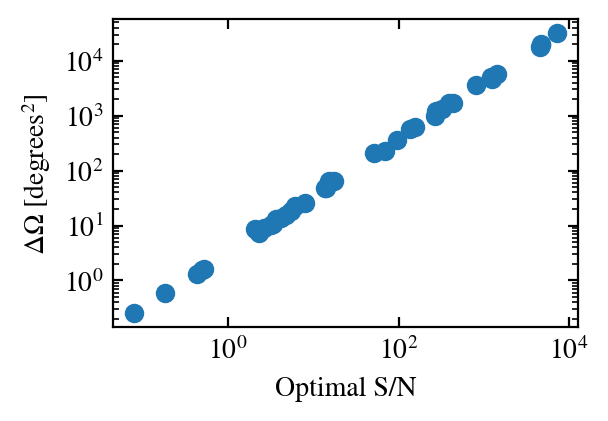

In [30]:
#plt.scatter(jnp.array(angles), 
#            jnp.array(omega_sky_vsnr), label='SNR=10');
#plt.scatter(jnp.array(snrs), 
#            jnp.array(omega_sky_vsnr), label='SNR=10');

plt.scatter(jnp.array(angles)**2.0 / jnp.array(snrs)**2.0, 
            jnp.array(omega_sky_vsnr), label='SNR=10');
#plt.scatter(jnp.array(angles)**2.0 / jnp.array(snrs)**2.0, 
#            jnp.array(omega_sky_vsnr_marg), label='SNR=10');
#plt.scatter(omega_wgtinterp(jnp.linspace(1.,70.,40)) / jnp.array(snrs)**2.0, 
#            jnp.array(omega_sky_vsnr), label='SNR=10');
#plt.scatter(omega_wgtinterp(jnp.linspace(1.,70.,40)) / jnp.array(snrs)**2.0, 
#            jnp.array(omega_sky_vsnr_marg), label='SNR=10');

#plt.plot(angles, jnp.array(omega_sky_vsnr), label='SNR=10');
#plt.plot(angles, jnp.array(omega_sky_vsnr_marg), label='SNR=10');

#plt.scatter(jnp.array(snrs), omega_sky_vsnr, label='SNR=10');
#plt.plot(jnp.array(angles)**2.0 / jnp.array(snrs)**2.0, 
#         jnp.array(angles)**2.0 / jnp.array(snrs)**2.0, label='$\propto \\theta_\mathrm{sep}^2$')

plt.xscale('log')
plt.yscale('log')
plt.xlabel('Optimal S/N')
plt.ylabel('$\Delta\Omega$ [degrees$^2$]')
plt.minorticks_on()
plt.tick_params(which='both',tick2On=True,direction='in')
#plt.legend()

fig = matplotlib.pyplot.gcf()
fig.set_size_inches(3, 2)

plt.show()

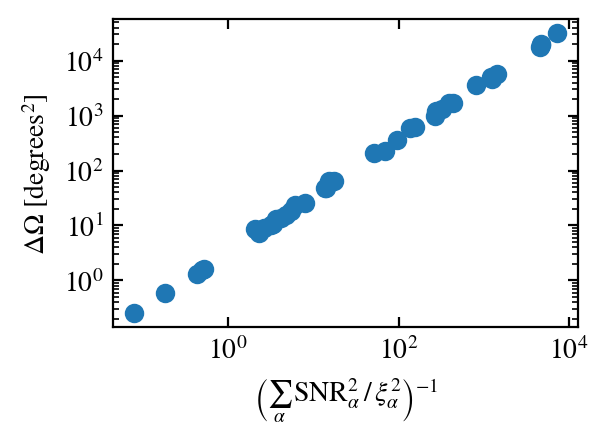

In [32]:
plt.scatter(jnp.array(angles)**2.0 / jnp.array(snrs)**2.0, 
            jnp.array(omega_sky_vsnr), label='SNR=10');
#plt.scatter(jnp.array(angles)**2.0 / jnp.array(snrs)**2.0, 
#            jnp.array(omega_sky_vsnr_marg), label='SNR=10');
#plt.scatter(omega_wgtinterp(jnp.linspace(1.,70.,40)) / jnp.array(snrs)**2.0, 
#            jnp.array(omega_sky_vsnr), label='SNR=10');
#plt.scatter(omega_wgtinterp(jnp.linspace(1.,70.,40)) / jnp.array(snrs)**2.0, 
#            jnp.array(omega_sky_vsnr_marg), label='SNR=10');

#plt.plot(angles, jnp.array(omega_sky_vsnr), label='SNR=10');
#plt.plot(angles, jnp.array(omega_sky_vsnr_marg), label='SNR=10');

#plt.scatter(jnp.array(snrs), omega_sky_vsnr, label='SNR=10');
#plt.plot(jnp.array(angles)**2.0 / jnp.array(snrs)**2.0, 
#         jnp.array(angles)**2.0 / jnp.array(snrs)**2.0, label='$\propto \\theta_\mathrm{sep}^2$')

plt.xscale('log')
plt.yscale('log')
plt.xlabel('$\left(\\sum_\\alpha\, \mathrm{SNR}_\\alpha^2 \,/\, \\xi_\\alpha^2\\right)^{-1}$')
plt.ylabel('$\Delta\Omega$ [degrees$^2$]')
plt.minorticks_on()
plt.tick_params(which='both',tick2On=True,direction='in')
#plt.legend()

fig = matplotlib.pyplot.gcf()
fig.set_size_inches(3, 2)

plt.show()

### Analytic average over phase, polarization, and inclination

If 1 pulsar, will keep at RA of pulsar and move DEC.

In [12]:
pars

{'cw_costheta': 0.5,
 'cw_phi': 1.5707963267948966,
 'cw_cosinc': 0.99,
 'cw_log10_Mc': 9.5,
 'cw_log10_fgw': -8.0,
 'cw_log10_dist': 2.385,
 'cw_phase0': 0.0,
 'cw_psi': 0.0}

In [59]:
angles = jnp.linspace(1.0,179.9,100)
#omega_sky_vsnr = []
#snrs = []

#seed = int(time.time() * 1e6) % (2**31 - 1)
#key = jax.random.PRNGKey(seed)

total_fisher_weight_sum = []
for ang in angles:
    #key, subkey = jax.random.split(key)
    #npsrs = int(jax.random.randint(subkey, (), 10, 51))
    #print(npsrs)

    psrs_ring = utils.pulsar_ring_generator(pars=pars, ang_radius=ang, npsrs=30, 
                                            toas=toas_new, toaerrs=toaerrs)
    #print(psrs_ring[1].ra, psrs_ring[1].dec)
    #print(psrs_ring[0]._pos)
    # calculate antenna pattern
    fisher_weight_sum = []
    for p in psrs_ring:
        param_vec = jnp.array([pars['cw_costheta'], pars['cw_phi']])
        # rebuild delays function
        def fp_func(vec):
            fplus, _, _ = utils.create_gw_antenna_pattern(p._pos, 
                                                           jnp.arccos(vec[0]), 
                                                           vec[1])
            return fplus
        def fc_func(vec):
            _, fcross, _ = utils.create_gw_antenna_pattern(p._pos, 
                                                           jnp.arccos(vec[0]), 
                                                           vec[1])
            return fcross
        # Jacobian: shape (n_params, n_toas)
        fp_jac = jax.jacrev(fp_func)(param_vec)
        fc_jac = jax.jacrev(fc_func)(param_vec)
        # “test” matrix and Fisher
        fisher_weight = jnp.outer(fp_jac, fp_jac) + jnp.outer(fc_jac, fc_jac)
        #print(-0.5*(1.0+jnp.cos(jnp.pi/2.0 - p.dec)), fp_func(param_vec), fp_jac, fc_func(param_vec), fc_jac)
        fisher_weight /= (fp_func(param_vec)**2 + fc_func(param_vec)**2)
        #print((fp_func(param_vec)**2 + fc_func(param_vec)**2))
        fisher_weight_sum.append(fisher_weight)

    #print(jnp.degrees(jnp.arccos(utils.create_gw_antenna_pattern(psrs_ring[0]._pos, 
    #                                                 jnp.arccos(pars['cw_costheta']), 
    #                                                 pars['cw_phi'])[2])), ang)
    total_fisher_weight_sum.append(jnp.sum(jnp.stack(fisher_weight_sum), axis=0))

    
    #fisher_inv = jnp.linalg.pinv(total_fisher)[:2,:2]
    #omega_sky_vsnr.append( (180/jnp.pi)**2 * 2.0*jnp.pi * jnp.linalg.det(fisher_inv)**0.5 )

/Users/taylosr8/Research/repos/pta_cw_fisher/utils.py:48: FutureWarning: None encountered in jnp.array(); this is currently treated as NaN. In the future this will result in an error.
  self.design_matrix = jnp.array(design_matrix)


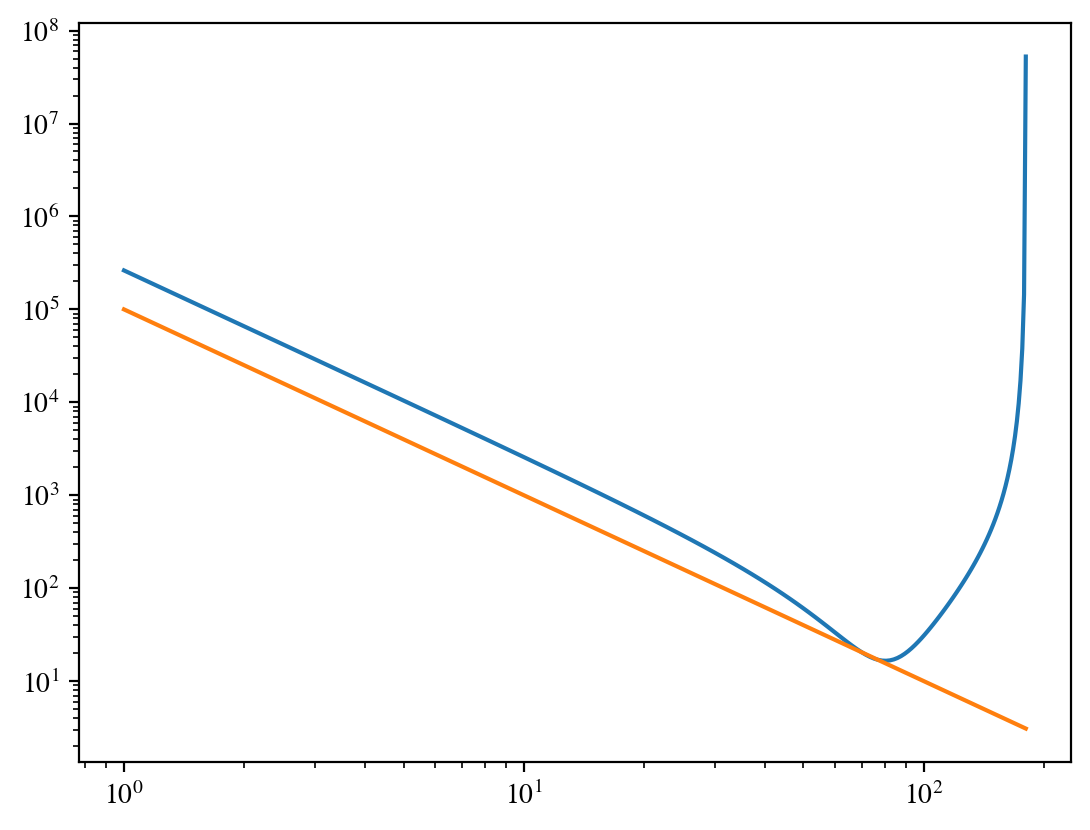

In [60]:
plt.loglog(angles,jnp.array(total_fisher_weight_sum)[:,0,0]);

#plt.loglog(angles,jnp.sin(jnp.radians(2.0*angles))**-2.0); # / (1.0 - jnp.cos(jnp.radians(angles)))**2.0);
#plt.loglog(angles,jnp.sin(jnp.radians(2.0*angles))**2.0 / (1.0 - jnp.cos(jnp.radians(angles)))**2.0);

#plt.loglog(angles,jnp.sin(jnp.radians(2.0*angles))**-2.0 + 0.5*jnp.sin(jnp.radians(2.0*angles))**2.0 / (1.0 - jnp.cos(jnp.radians(angles)))**2.0);

plt.loglog(angles,1e5/jnp.array(angles)**2.0);
plt.show()

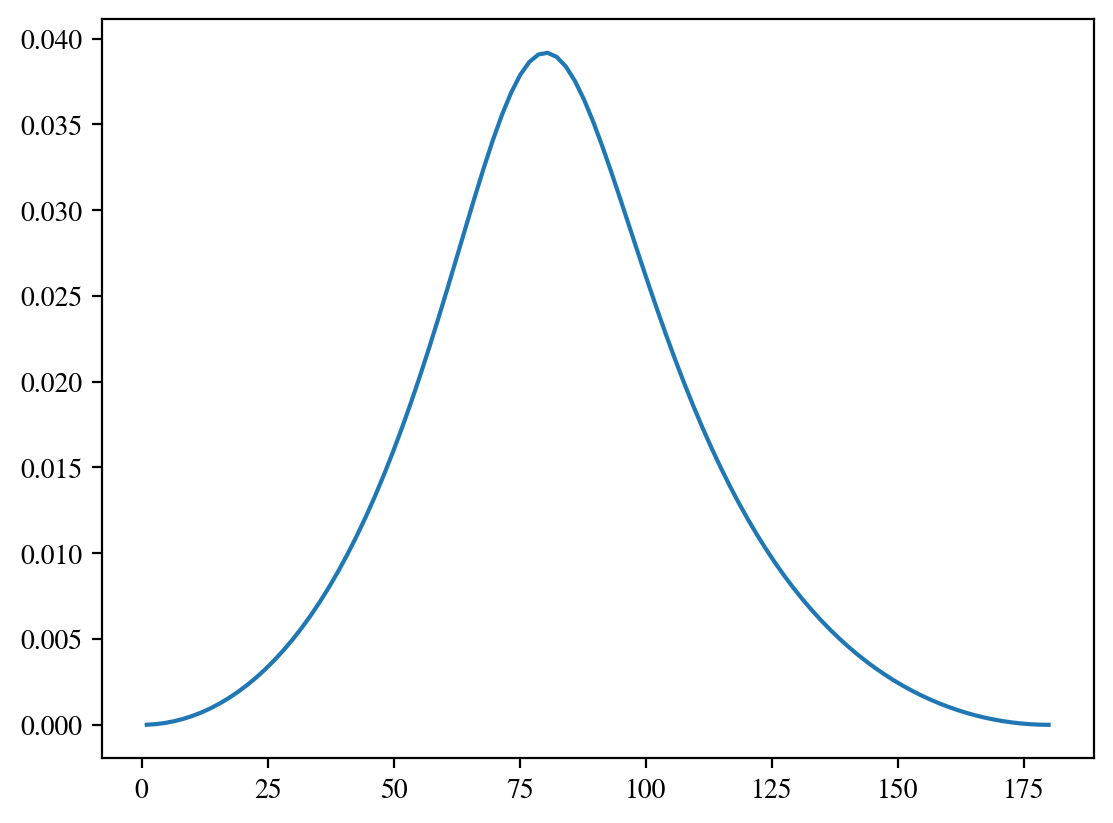

In [67]:
#plt.loglog(angles, [1.0/jnp.linalg.det(ttfws)**0.5 for ttfws in jnp.array(total_fisher_weight_sum)]);
#plt.loglog(angles, 0.04*jnp.sin(jnp.radians(angles))**2.0);

plt.plot(angles, [1.0/jnp.linalg.det(ttfws)**0.5 for ttfws in jnp.array(total_fisher_weight_sum)]);
#plt.plot(angles, 0.04*jnp.sin(jnp.radians(angles))**4.0);
#plt.loglog(angles, (1.0-jnp.cos(jnp.radians(angles))));

In [68]:
# compute ω(θ) on your existing grid once
omega_weights = jnp.array([1.0/jnp.linalg.det(w)**0.5 for w in total_fisher_weight_sum])

# define an interpolant function
def omega_wgtinterp(theta):
    """
    interpolate sky‐localization area ω as a function of pulsar‐separation angle θ
    supports both scalars and array inputs
    """
    return jnp.interp(theta, angles, omega_weights)

# example usage:
print(omega_wgtinterp(20.0))             # scalar input
print(omega_wgtinterp(jnp.linspace(1,179,5)))  # vector input

0.002119516629781016
[5.07747252e-06 1.28196931e-02 3.48036597e-02 6.17423523e-03
 4.61207379e-06]


In [72]:
# Convert JAX arrays to NumPy arrays for saving
angles_np = np.array(angles)
omega_weights_np = np.array(omega_weights)

# Save the arrays to a compressed .npz file
np.savez('omega_interpolation_data.npz', angles=angles_np, omega_weights=omega_weights_np)

print("Interpolation data saved to omega_interpolation_data.npz")

Interpolation data saved to omega_interpolation_data.npz


### Sanity checks and diff tests

In [56]:
param_vec = jnp.array([0.0, 0.0])
test_omega_var = []
test_seps = []
for alpha in jnp.radians(jnp.linspace(0.0, 50.0, 10)):
    #alpha = jnp.radians(10.0)  # Example angle for pulsar position
    test_pulsar_position = jnp.array([jnp.cos(alpha), 0.0, jnp.sin(alpha)])  # Example pulsar position
    origin = jnp.array([jnp.sin(jnp.arccos(param_vec[0])) * jnp.cos(param_vec[1]),
                       jnp.sin(jnp.arccos(param_vec[0])) * jnp.sin(param_vec[1]),
                       jnp.cos(jnp.arccos(param_vec[0]))])
    #print(test_pulsar_position, origin)
    # rebuild delays function
    def fp_func(vec):
        fplus, _, _ = utils.create_gw_antenna_pattern(test_pulsar_position, 
                                                        jnp.arccos(vec[0]), 
                                                        vec[1])
        return fplus
    def fc_func(vec):
        _, fcross, _ = utils.create_gw_antenna_pattern(test_pulsar_position, 
                                                        jnp.arccos(vec[0]), 
                                                        vec[1])
        return fcross
    # Jacobian: shape (n_params, n_toas)
    fp_jac = jax.jacrev(fp_func)(param_vec)
    fc_jac = jax.jacrev(fc_func)(param_vec)
    # “test” matrix and Fisher
    fisher_weight = jnp.outer(fp_jac, fp_jac) + jnp.outer(fc_jac, fc_jac)
    fisher_weight /= (fp_func(param_vec)**2 + fc_func(param_vec)**2)
    cosMu = utils.create_gw_antenna_pattern(test_pulsar_position, 
                                            jnp.arccos(param_vec[0]), 
                                            param_vec[1])[2]
    #test_omega_var.append(1.0/jnp.linalg.det(fisher_weight)**0.5)
    test_omega_var.append(fisher_weight)
    test_seps.append(jnp.degrees(jnp.arccos(cosMu)))
    print(jnp.degrees(jnp.arccos(cosMu)))

0.0
5.55555555555555
11.111111111111107
16.666666666666664
22.222222222222214
27.77777777777777
33.33333333333333
38.888888888888886
44.44444444444444
49.99999999999999


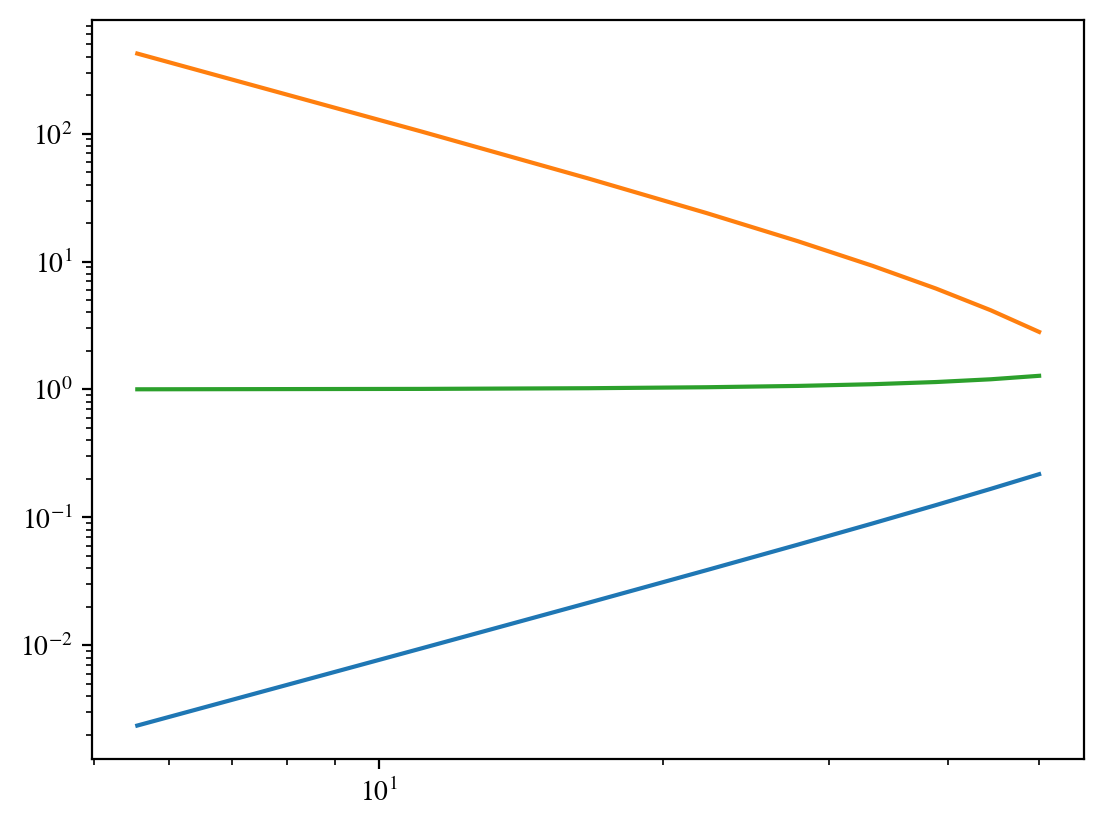

In [57]:
plt.loglog(test_seps, jnp.array(test_omega_var)[:,0,0], label='Test Omega Variance');
plt.loglog(test_seps, jnp.array(test_omega_var)[:,1,1], label='Test Omega Variance');
plt.loglog(test_seps, [1.0/jnp.linalg.det(ttfws)**0.5 for ttfws in test_omega_var], label='Test Omega Variance');
#plt.loglog(test_seps, 2/(1.0+jnp.cos(jnp.radians(test_sep_angles))), label='Test Omega Variance');
plt.show()

#### JAX differentiation tests

In [11]:
psrs_one = utils.pulsar_ring_generator(pars=pars, ang_radius=40.0, npsrs=1, 
                                            toas=toas_new, toaerrs=toaerrs)

def fp_func(costheta):
    fplus, _, _ = utils.create_gw_antenna_pattern(psrs_one[0]._pos, 
                                                    jnp.arccos(costheta), 
                                                    0.0)
    return fplus

In [12]:
jnp.diff(jnp.array([fp_func(ctheta) for ctheta in jnp.linspace(-1.0e-5, 1.0e-5, 10)])) / jnp.diff(jnp.linspace(-1.0e-5, 1.0e-5, 10))

Array([-0.32521133, -0.32521049, -0.32520964, -0.3252088 , -0.32520796,
       -0.32520711, -0.32520627, -0.32520542, -0.32520458], dtype=float64)

Confirmed that finite difference also agrees with JAX.